In [1]:
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
from xgcm import Grid
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

In [2]:
#load pre-subsetted file (if available), otherwise uncomment the cells above and below this one
datapath = '/srv/scratch/z3526974/ROMS_at_mooring_sites/CH/'
ts = xr.open_mfdataset(datapath + 'CH*.nc', chunks={'ocean_time': 1}, combine='by_coords', decode_coords=True)

# Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108

Here I also test to see if the new XGCM 'metrics' functionality works.

In [3]:
# Including metrics
ds = ts.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

/home/z3526974/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  from ipykernel import kernelapp as app
/home/z3526974/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  app.launch_new_instance()


In [4]:
grid

<xgcm.Grid>
X Axis (not periodic):
  * center   xi_rho --> inner
  * inner    xi_u --> center
Y Axis (not periodic):
  * center   eta_rho --> inner
  * inner    eta_v --> center
Z Axis (not periodic):
  * center   s_rho --> outer
  * outer    s_w --> center

In [5]:
#calculate temperature advection at each gridpoint
ds['T_u'] = grid.interp(ds.u, axis='X', boundary = 'extend')*ds.temp
ds['T_v'] = grid.interp(ds.v, axis='Y', boundary = 'extend')*ds.temp

ds['T_uz'] = (grid.integrate(ds.T_u, 'Z'))/ds.h
ds['T_vz']= (grid.integrate(ds.T_v, 'Z'))/ds.h
ds.T_uz

,Array,Chunk
Bytes,5.32 MB,512 B
Shape,"(8309, 8, 10)","(1, 8, 8)"
Count,872509 Tasks,24927 Chunks
Type,float64,numpy.ndarray


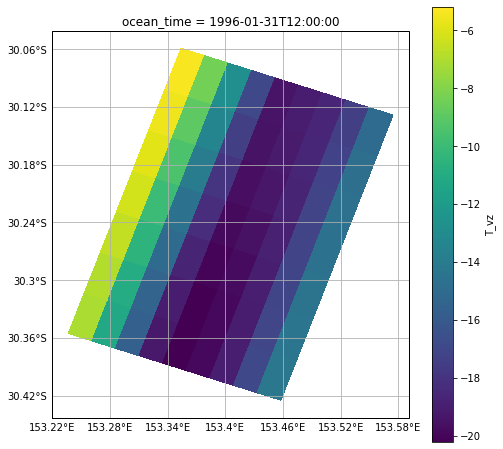

In [6]:
fig = plt.figure(figsize=(8,8))
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
ax = plt.axes(projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
ds.T_vz.sel(ocean_time='1996-01-31T12').plot(ax=ax, transform=ccrs.PlateCarree(), 
                                        x='lon_rho', y='lat_rho')
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = gl.ylabels_right = False

In [7]:
#Calculate heat transport
Cp = 4181.3
Rho_0 = 1025

In [1]:
s = (Cp*Rho_0*grid.integrate(ds.T_vz, 'X').sel(eta_rho=-1)).load()
n = (Cp*Rho_0*grid.integrate(ds.T_vz, 'X').sel(eta_rho=0)*-1).load()
w = (Cp*Rho_0*grid.integrate(ds.T_uz, 'Y').sel(xi_rho=0)*-1).load()
e = (Cp*Rho_0*grid.integrate(ds.T_uz, 'Y').sel(xi_rho=-1)).load()
tot_heat_adv = ((n+s+e+w)/(ds.dx_u[0,0,:].sum()ds.dy_u[0,0,:].sum()))*-1 #     ((ii-i)*(jj-j)*2500*5000)

NameError: name 'Cp' is not defined

Text(0.5, 1.0, 'heat transport into box')

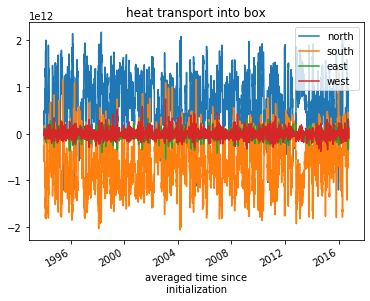

In [9]:
n.plot(label='north')
s.plot(label='south')
e.plot(label='east')
w.plot(label='west')
plt.legend()
plt.title('heat transport into box')
#plt.savefig('heat_transport.png', dpi=300,bbox_inches='tight')

Text(0.5, 1.0, 'monthly heat transport into box')

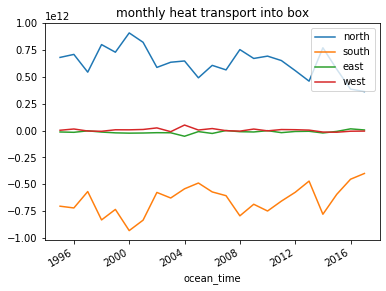

In [10]:
n.resample(ocean_time='1Y').mean().plot(label='north')
s.resample(ocean_time='1Y').mean().plot(label='south')
e.resample(ocean_time='1Y').mean().plot(label='east')
w.resample(ocean_time='1Y').mean().plot(label='west')
plt.legend()
plt.title('monthly heat transport into box')

Text(0.5, 1.0, 'total heat transport into box')

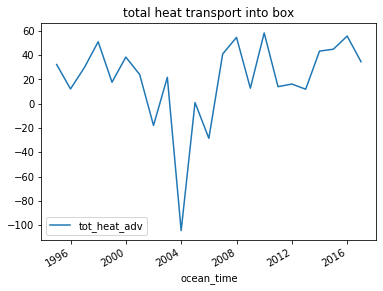

In [11]:
tot_heat_adv.resample(ocean_time='1Y').mean().plot(label='tot_heat_adv')
plt.legend()
plt.title('total heat transport into box')
#plt.savefig('heat_transport.png', dpi=300,bbox_inches='tight')

In [12]:
tot_heat_adv.mean().values

array(19.99253275)

In [13]:
# Surface heat flux (per m2)
tot_Q = (grid.integrate(ds.shflux, ['X','Y']))/(ds.dx_u[0,0,:].sum()*ds.dy_u[0,0,:].sum()).load()

In [14]:
tot_Q.mean().values

array(-168.99189663)

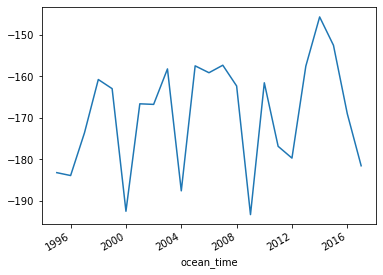

In [15]:
tot_Q.resample(ocean_time='1Y').mean().plot()

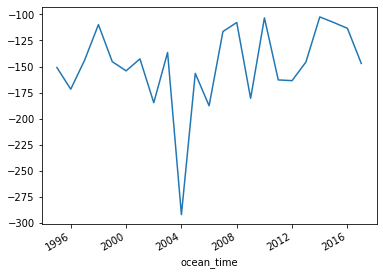

In [16]:
tendency = tot_heat_adv + tot_Q
tendency.resample(ocean_time='1Y').mean().plot()

In [18]:
# Temperature tendency
Temp_z0 = (grid.integrate(ds.temp,'Z'))/ds.h
Temp_z = Temp_z0*Rho_0*Cp
Temp_tend = (grid.integrate(Temp_z,['X','Y']))/(ds.dx_u[0,0,:].sum()*ds.dy_u[0,0,:].sum())
Temp_tend = Temp_tend - Temp_tend.mean()

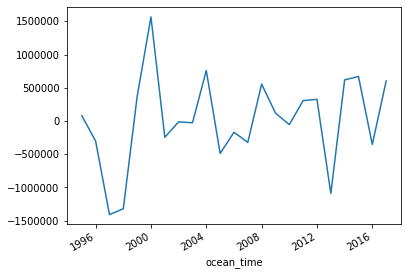

In [19]:
Temp_tend.resample(ocean_time='1Y').mean().plot()

In [20]:
Temp_z0

,Array,Chunk
Bytes,5.32 MB,640 B
Shape,"(8309, 8, 10)","(1, 8, 10)"
Count,398887 Tasks,8309 Chunks
Type,float64,numpy.ndarray


In [21]:
test = Temp_z0.mean(dim = ['eta_rho','xi_rho'])

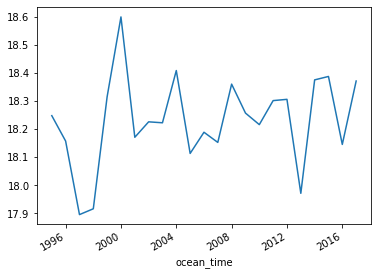

In [22]:
test.resample(ocean_time='1Y').mean().plot()

In [75]:
ds.shflux

,Array,Chunk
Bytes,2.49 MB,320 B
Shape,"(7769, 8, 10)","(1, 8, 10)"
Count,15546 Tasks,7769 Chunks
Type,float32,numpy.ndarray
